In [253]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['class'] = wine.target
# choose chemistry-important features
chem_feats = ["total_phenols", "flavanoids", "color_intensity"]

# compute composite phenolic score
df["phenolic_score"] = df[chem_feats].mean(axis=1)

threshold = 3#df["phenolic_score"].median()

source = df[df["phenolic_score"] <= threshold]   # light wines
target = df[df["phenolic_score"] > threshold]    # full-bodied wines


In [254]:
threshold

3

In [255]:
# Khởi tạo scaler
feature_cols = wine.feature_names
scaler = StandardScaler()

# Chuẩn hóa riêng từng nhóm
source_scaled = source.copy()
target_scaled = target.copy()

source_scaled[feature_cols] = scaler.fit_transform(source[feature_cols])
target_scaled[feature_cols] = scaler.fit_transform(target[feature_cols])

In [256]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class,phenolic_score
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,3.833333
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,3.263333
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,3.906667
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,5.046667
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,3.270000


In [257]:
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

c:\Users\Asus\anaconda3\envs\dann\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


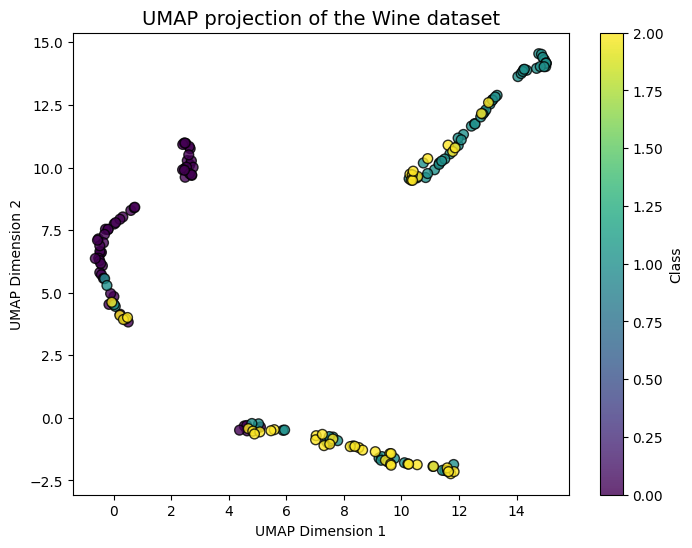

In [258]:
import umap
X = df.drop('class', axis=1)
y = df['class']

# Apply UMAP for 2D projection
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y,
    cmap='viridis',
    s=50,
    alpha=0.8,
    edgecolor='k'
)

plt.title("UMAP projection of the Wine dataset", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Class")
plt.show()

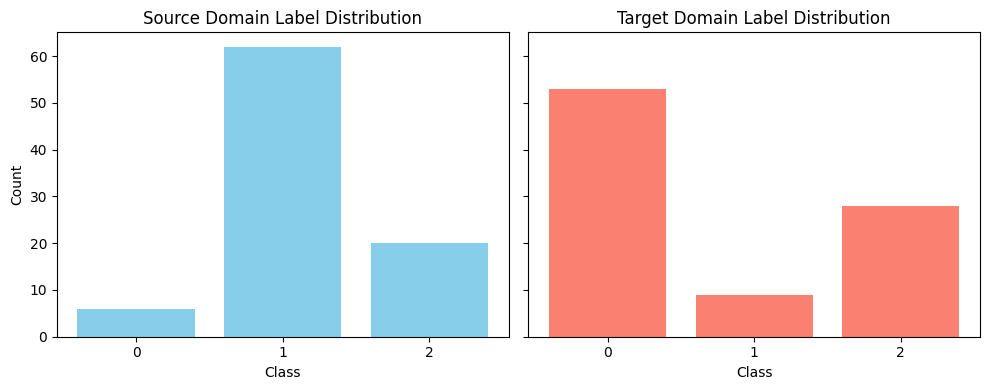

In [259]:
import matplotlib.pyplot as plt
# Compute label distributions
source_label_dist = source['class'].value_counts().sort_index()
target_label_dist = target['class'].value_counts().sort_index()

labels = source_label_dist.index.tolist()
x = range(len(labels))

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Source plot
axes[0].bar(x, source_label_dist, color='skyblue')
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].set_title("Source Domain Label Distribution")

# Target plot
axes[1].bar(x, target_label_dist, color='salmon')
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_xlabel("Class")
axes[1].set_title("Target Domain Label Distribution")

# Adjust layout and show
plt.tight_layout()
plt.show()

c:\Users\Asus\anaconda3\envs\dann\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


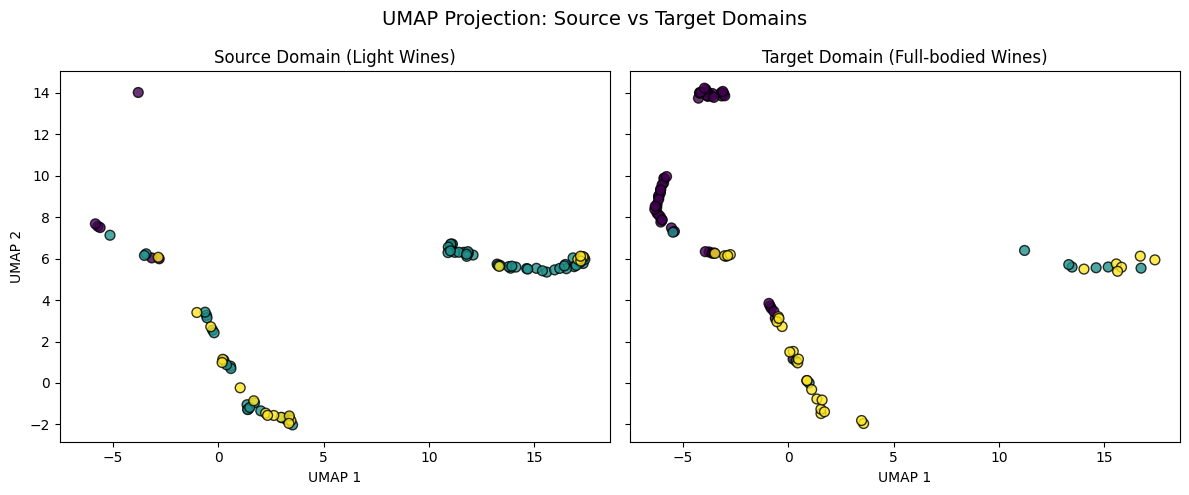

In [260]:
# Separate features and labels
X_source, y_source = source.drop(["class", "phenolic_score"], axis=1), source["class"]
X_target, y_target = target.drop(["class", "phenolic_score"], axis=1), target["class"]
# Fit UMAP on all data to ensure comparable embeddings
reducer = umap.UMAP(random_state=42)
embedding_all = reducer.fit_transform(df.drop(["class", "phenolic_score"], axis=1))

# Map embeddings back to source/target
embedding_source = embedding_all[source.index]
embedding_target = embedding_all[target.index]

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Source subplot
axes[0].scatter(
    embedding_source[:, 0],
    embedding_source[:, 1],
    c=y_source,
    cmap="viridis",
    s=50,
    alpha=0.8,
    edgecolor="k"
)
axes[0].set_title("Source Domain (Light Wines)")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

# Target subplot
axes[1].scatter(
    embedding_target[:, 0],
    embedding_target[:, 1],
    c=y_target,
    cmap="viridis",
    s=50,
    alpha=0.8,
    edgecolor="k"
)
axes[1].set_title("Target Domain (Full-bodied Wines)")
axes[1].set_xlabel("UMAP 1")

plt.suptitle("UMAP Projection: Source vs Target Domains", fontsize=14)
plt.tight_layout()
plt.show()

In [261]:
import os
import time
import yaml
import numpy as np
import torch
from torch.utils.data import TensorDataset
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import umap
from sklearn.manifold import TSNE
import pandas as pd
from models.wdgrl import WDGRL

In [262]:
X_s = X_source.to_numpy()
X_t = X_target.to_numpy()

In [263]:
ns, nt = X_s.shape[0], X_t.shape[0]
d = X_s.shape[1]
d

13

In [264]:
xs = torch.from_numpy(X_s).double()
xt = torch.from_numpy(X_t).double()

source_dataset = TensorDataset(xs)
target_dataset = TensorDataset(xt)


In [281]:
# ==== WDGRL model ====
final_model = WDGRL(
    input_dim=d,
    encoder_hidden_dims=[200,100],
    critic_hidden_dims=[100],
    alpha1=0.0001,
    alpha2=0.00001,
    seed=42,
)

# ==== Logging setup ====
timestamp = time.strftime("%Y%m%d-%H%M%S")+'-mnist-usps'
log_dir = os.path.join("logs", timestamp)
os.makedirs(log_dir, exist_ok=True)

log_file = os.path.join(log_dir, "results.txt")
log_loss = final_model.train(
    source_dataset,
    target_dataset,
    num_epochs=2000,
    gamma=7,
    dc_iter=5,
    batch_size=32,
    # early_stopping=True,
    model_path=log_dir,
)

final_model.save_model(log_dir)

# ==== Save logs ====
total_loss = log_loss["loss"]

Epoch: 100%|██████████| 2000/2000 [01:05<00:00, 30.76it/s]

Encoder and Critic saved to logs\20251111-085516-mnist-usps


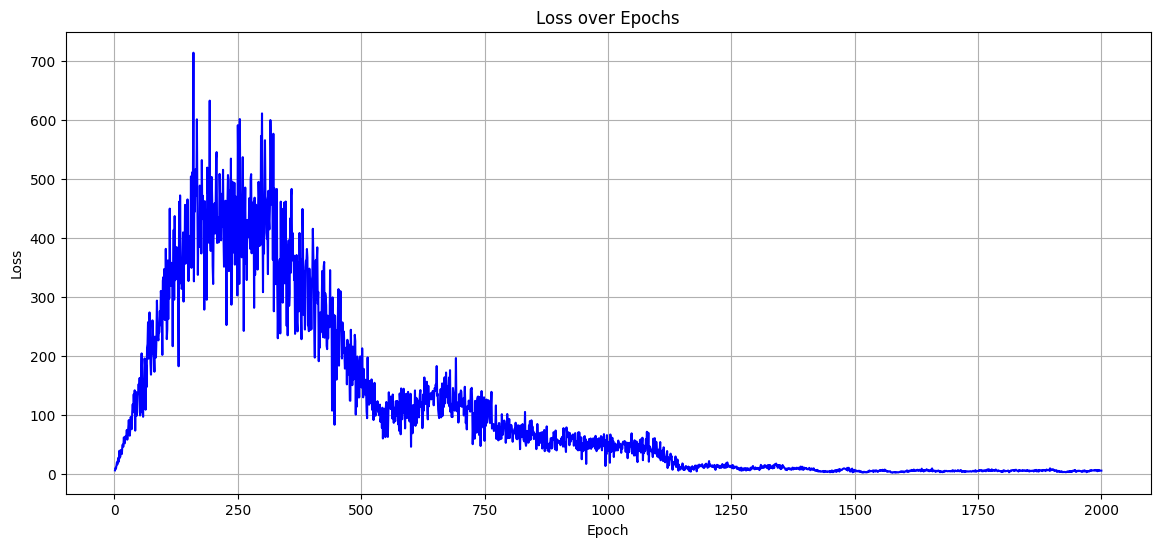

In [282]:
epochs = range(1, len(total_loss) + 1)

plt.figure(figsize=(14, 6))
plt.plot(epochs, total_loss, linestyle='-', color='blue')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim(0, 1.0)
plt.grid(True)
plt.savefig(os.path.join(log_dir, "loss.png"))
plt.show()
plt.close()

In [283]:
xs_hat = final_model.extract_feature(xs.cuda())
xt_hat = final_model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()

UMAP shape: (150, 2)


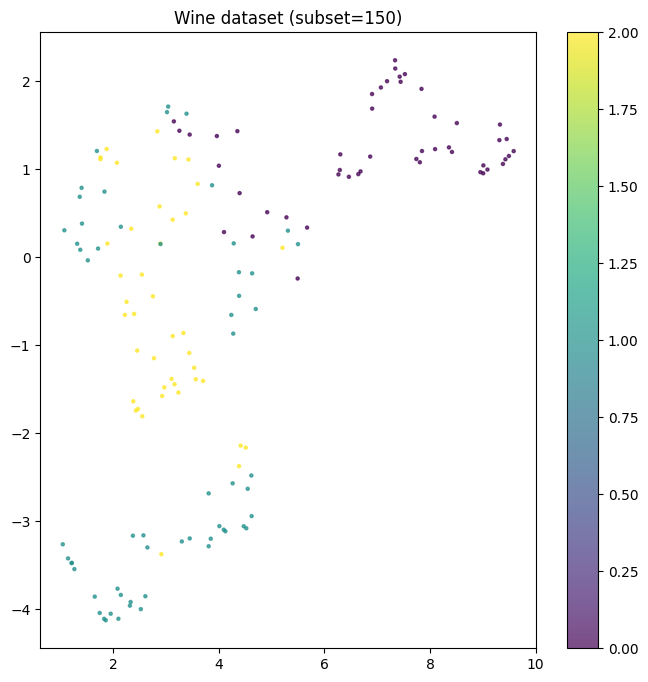

In [285]:
# Stack features and use the correct label arrays (source = y_train, target = y_usps_train)
X_all = np.vstack([xs_hat, xt_hat])
y_all = np.concatenate([y_source, y_target])

# Create domain labels (0=source, 1=target)
domain_all = np.concatenate([
    np.zeros(len(xs_hat), dtype=int),
    np.ones(len(xt_hat), dtype=int)
])

# sample subset for faster t-SNE (sample consistently from X, y and domain)
num_samples = 150
indices = np.random.choice(X_all.shape[0], num_samples, replace=False)

X_sub = X_all[indices]
y_sub = y_all[indices]
domain_sub = domain_all[indices]

# ✅ UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean")
X_umap = reducer.fit_transform(X_sub)

print("UMAP shape:", X_umap.shape)

# ✅ plot
plt.figure(figsize=(8,8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_sub, s=5, cmap="viridis", alpha=0.7)
plt.colorbar(scatter)
plt.title(f"Wine dataset (subset={num_samples})")
plt.show()